In [4]:
import xarray as xr
import os
import glob
import numpy as np
import warnings
import matplotlib.pyplot as plt
import sys

sys.path.append(os.path.abspath('../src-double-gyre'))
sys.path.append(os.path.abspath('../src'))
warnings.filterwarnings("ignore")
from helpers.collection_of_experiments import CollectionOfExperiments
from plot_helpers import *

%load_ext autoreload
%autoreload 3

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
ds = CollectionOfExperiments.init_folder('/scratch/pp2681/mom6/Feb2022/bare', additional_subfolder='output')

In [6]:
ds += CollectionOfExperiments.init_folder('/scratch/pp2681/mom6/Apr2023/R4-sensitivity', additional_subfolder='output')

In [23]:
for RR in ['R4', 'R64', 'ZB-stress-pass-4-sel-1-Cs-0.06-ZB-1.0']:
    ds.remesh(RR, 'R1')
    ds.remesh(RR, 'R2')
    if RR != 'R4':
        ds.remesh(RR, 'R4')

Experiment R4 coarsegrained to R1 is created. Its identificator=R4_R1
Experiment R4 coarsegrained to R2 is created. Its identificator=R4_R2
Experiment R64 coarsegrained to R1 is created. Its identificator=R64_R1
Experiment R64 coarsegrained to R2 is created. Its identificator=R64_R2
Experiment R64 coarsegrained to R4 is created. Its identificator=R64_R4
Experiment ZB-stress-pass-4-sel-1-Cs-0.06-ZB-1.0 coarsegrained to R1 is created. Its identificator=ZB-stress-pass-4-sel-1-Cs-0.06-ZB-1.0_R1
Experiment ZB-stress-pass-4-sel-1-Cs-0.06-ZB-1.0 coarsegrained to R2 is created. Its identificator=ZB-stress-pass-4-sel-1-Cs-0.06-ZB-1.0_R2
Experiment ZB-stress-pass-4-sel-1-Cs-0.06-ZB-1.0 coarsegrained to R4 is created. Its identificator=ZB-stress-pass-4-sel-1-Cs-0.06-ZB-1.0_R4


# Choosing the coarsest mesh possible for optimization problem
We choose coarse resolution 1 degree mostly to be prepared for global ocean model

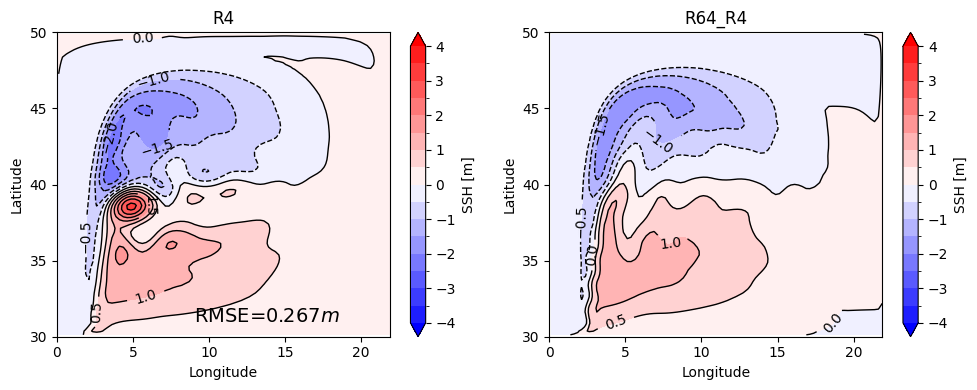

In [65]:
ds.plot_ssh(['R4', 'R64_R4'])

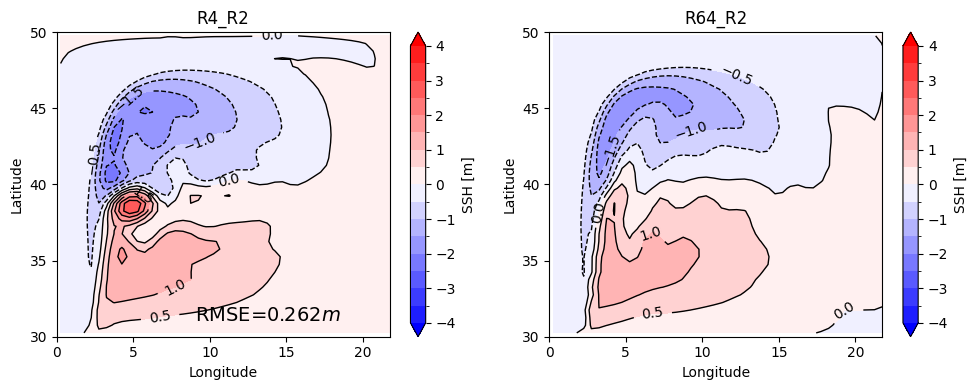

In [66]:
ds.plot_ssh(['R4_R2', 'R64_R2'])

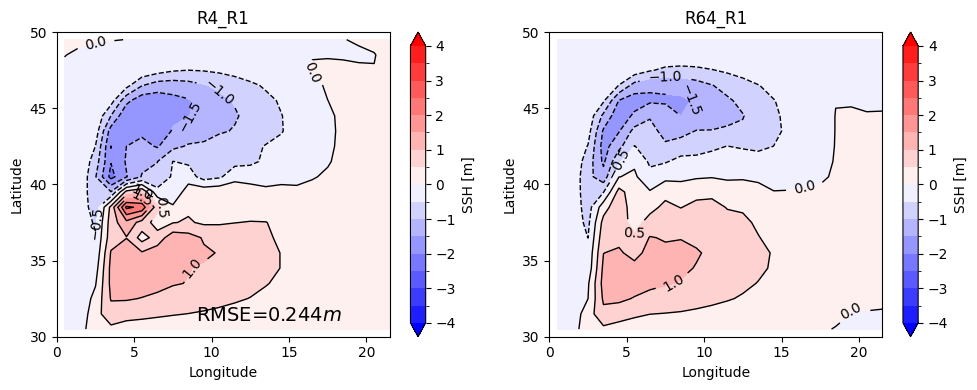

In [67]:
ds.plot_ssh(['R4_R1', 'R64_R1'])

In [114]:
ds['R4_R1'].ssh_mean.data.ravel().shape

(440,)

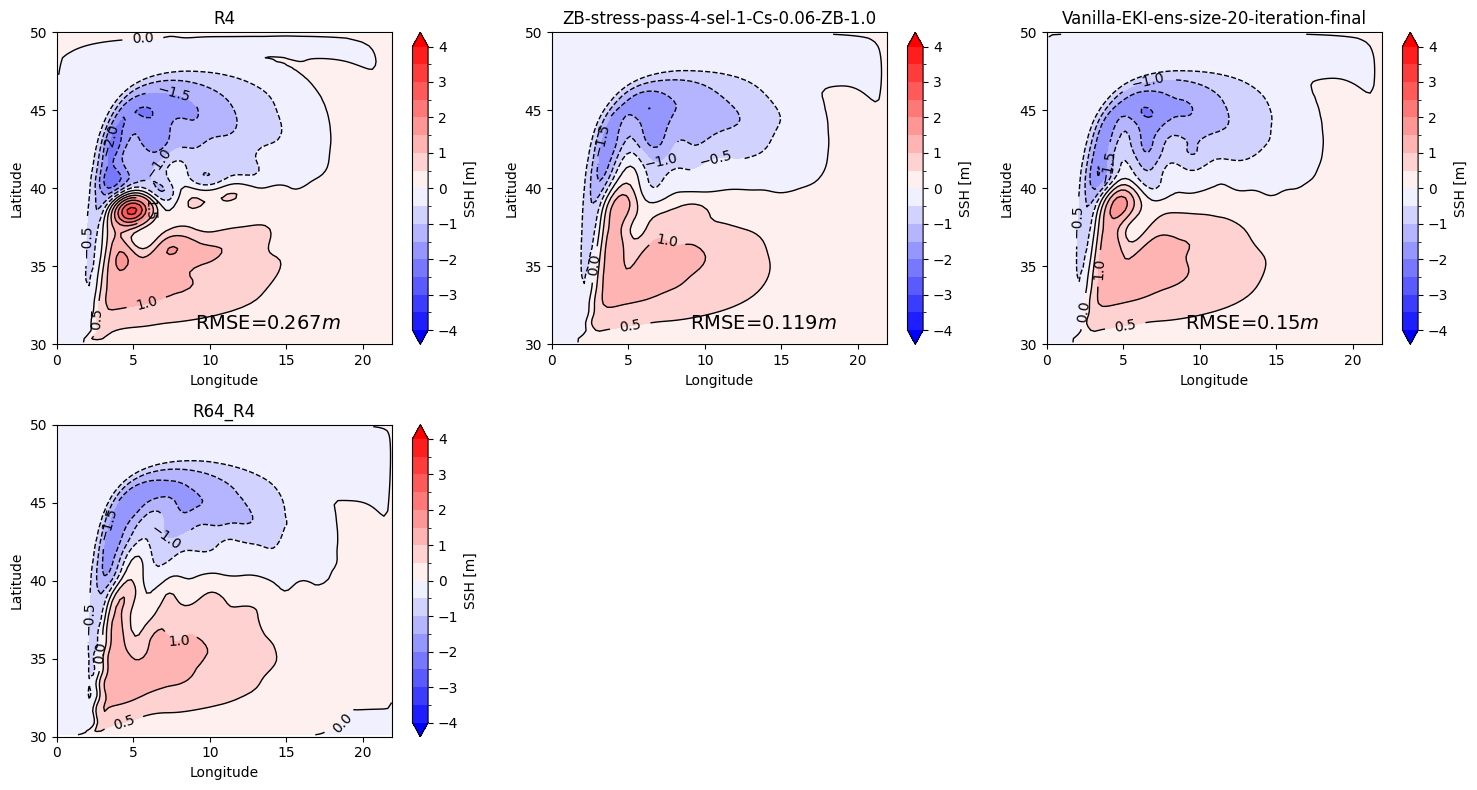

In [65]:
ds.plot_ssh(['R4', 'ZB-stress-pass-4-sel-1-Cs-0.06-ZB-1.0', 'Vanilla-EKI-ens-size-20-iteration-final', 'R64_R4'])

# Compute error covariance matrix from internal variability of coarse and high-resolution models

In [99]:
Noise_variance = (ds['R4_R1'].ea.coarsen({'Time':60}, boundary='trim').mean()[1:].isel(zi=0).var('Time') + \
                 ds['R64_R1'].ea.coarsen({'Time':60}, boundary='trim').mean()[1:].isel(zi=0).var('Time')).compute()

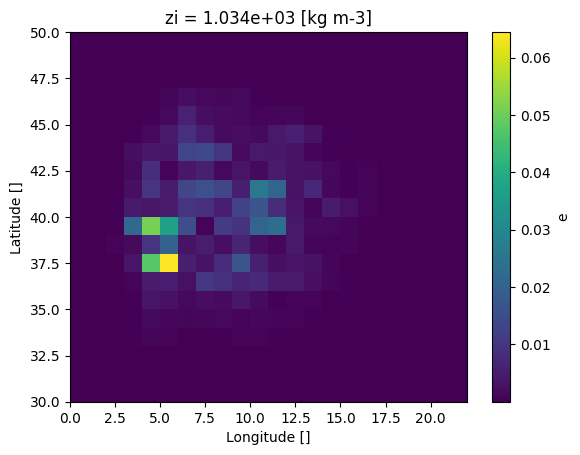

In [104]:
Noise_variance.plot()

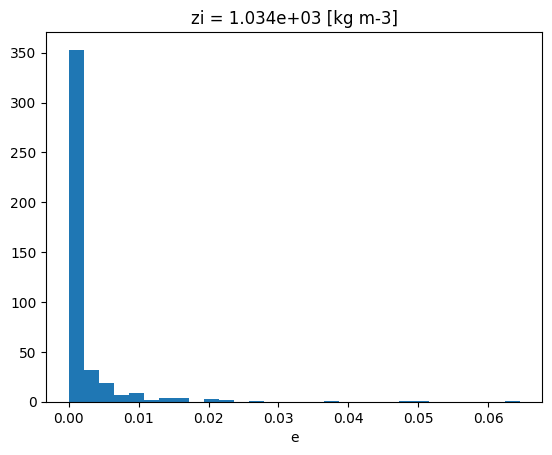

In [111]:
# For the first iteration, we do not want to provide a very accurate noise covariance matrix. Mostly because this would change the optimization objective which is different from our target (RMSE).
# We use noise variance 0.01 which holds most of the support of the variance distribution.
Noise_variance.plot.hist(bins=30);

# Justification of choosing time-averaging interval

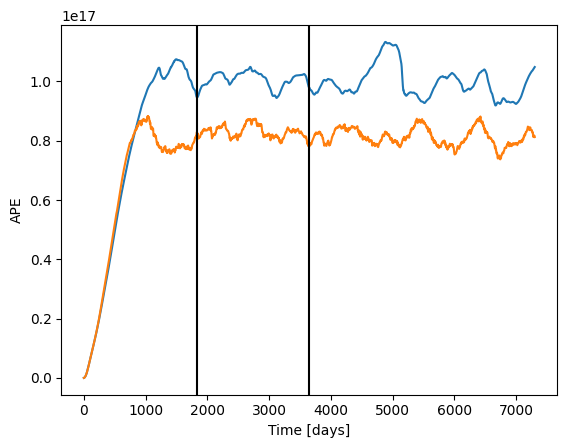

In [130]:
ds['R4'].series.APE.sum('Interface').plot()
ds['R64'].series.APE.sum('Interface').plot()
plt.axvline(x=365*5, color='k')
plt.axvline(x=365*10, color='k')

In [137]:
np.isnan(ds['R4'].ea[-1][0].coarsen({'xh':4, 'yh':4}).mean()).sum().compute()

<xarray.DataArray 'e' ()> Size: 8B
array(0)
Coordinates:
    Time     float64 8B 7.275e+03
    zi       float64 8B 1.034e+03

In [62]:
# Role of choosing the target
np.sqrt((((ds['R64_R1'].ea.coarsen({'Time':60}, boundary='trim').mean()[1] - ds['R64_R1'].ea.coarsen({'Time':60}, boundary='trim').mean()[1:].mean('Time')).isel(zi=0))**2).mean().compute())

<xarray.DataArray 'e' ()> Size: 4B
array(0.02700522, dtype=float32)
Coordinates:
    Time     float64 8B 2.7e+03
    zi       float64 8B 1.034e+03

# Analysis of the parameter's convergence

In [184]:
metrics = xr.open_dataset('/scratch/pp2681/mom6/Apr2023/R4-sensitivity/Vanilla-EKI-ens-size-20/metrics.nc')

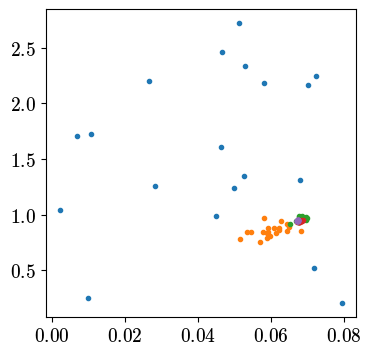

In [185]:
for iter in range(5):
    plt.plot(metrics.Cs[iter], metrics.ZB[iter], '.')

In [186]:
rmse_train = np.sqrt(((metrics.ssh_coarse - metrics.ssh_fine)**2).mean(['yh', 'xh']))
rmse_mean_train = np.sqrt(((metrics.ssh_coarse.mean('ens') - metrics.ssh_fine)**2).mean(['yh', 'xh'])) # Metric used by Dunbar
rmse_mean_test = np.sqrt(((metrics.ssh_coarse.mean('ens') - ds['R64_R1'].ssh_mean)**2).mean(['yh', 'xh']))

Text(0.5, 1.0, '')

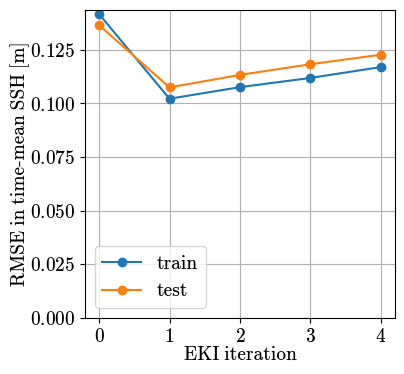

In [187]:
rmse_mean_train.plot(marker='o', label='train')
rmse_mean_test.plot(marker='o', label='test')
plt.legend()
plt.ylim([0,None])
plt.grid()
plt.ylabel('RMSE in time-mean SSH [m]')
plt.xlabel('EKI iteration')
plt.xticks(np.arange(0,5));
plt.title('')

# Animation of particles on the loss landscape

In [188]:
from helpers.computational_tools import Lk_error
def error_ssh(exp):
    return Lk_error(ds[exp].ssh_mean,ds['R64_R4'].ssh_mean)[0]

In [189]:
from functools import cache
@cache
def error_2d(error_function = error_ssh, prefix='ZB-clean'):
    ZBs = sorted([float(exp.split('-')[-1]) for exp in ds.exps if f'{prefix}-Cs-0.03' in exp])
    Css = sorted(set([float(exp.split('-')[-3]) for exp in ds.exps if f'{prefix}-Cs-' in exp]))
    
    error = np.zeros((len(ZBs), len(Css)))
    for i, Cs in enumerate(Css):
        for j, ZB in enumerate(ZBs):
            try:
                error[j,i] = error_function(f'{prefix}-Cs-{Cs:.2f}-ZB-{ZB}')
            except:
                error[j,i] = np.nan
    error = xr.DataArray(error, dims=['ZB', 'Cs'], coords={'Cs': Css, 'ZB': ZBs})
    return error

In [190]:
error_ssh('ZB-stress-pass-4-sel-1-Cs-0.06-ZB-1.0')

0.118933715

In [191]:
ssh = {'v0': 0.26709399, 'vmin': 0.0, 'error_function': error_ssh, 
           'cbar_ticks': np.arange(0.0,0.7,0.05), 
           'cbar_extend': 'neither', 'cbar_label': 'RMSE in \ntime-mean SSH, $\mathrm{m}$'};

In [192]:
def plot_panels(exps, labels, v0, vmin, error_function, color='w', cbar_ticks=None, cbar_extend='none', cbar_label=''):
    vmin=0.00; vmax=0.3

    for col in range(len(exps)):
        label=labels[col]
        exp=exps[col]
        e = error_2d(error_function = error_function, prefix=exp)
        X,Y = np.meshgrid(e.Cs, e.ZB)
        em = np.ma.masked_invalid(e)
        im = plt.pcolor(X,Y,em,vmin=vmin,vmax=vmax,cmap='RdBu_r')
        # https://stackoverflow.com/questions/35905393/python-leave-numpy-nan-values-from-matplotlib-heatmap-and-its-legend
        plt.gca().patch.set(hatch='OO', edgecolor='black')
        
        cb = plt.colorbar(im, fraction=0.3, pad=0.05, aspect=15, ticks=cbar_ticks, extend=cbar_extend)
        cb.set_label('RMSE [m]', fontsize=16, labelpad=10)
        if col<len(exps)-1:
            cb.ax.set_yticklabels(['']*len(cbar_ticks))
            cb.set_label('')
        
        plt.xticks(e.Cs.values, rotation=60)
        if len(e.ZB) > 16:
            plt.yticks(e.ZB.values[::2])
        else:
            plt.yticks(e.ZB.values)
            
        plt.xlabel('')
        if col==0:
            plt.ylabel('ZB scaling coefficient, $\gamma$', fontsize=20)
        else:
            plt.ylabel('')
        plt.title('ZB20-Smooth')
        plt.xlabel('Smagorinsky coefficient $C_S$', ha='center', fontsize=16)
    

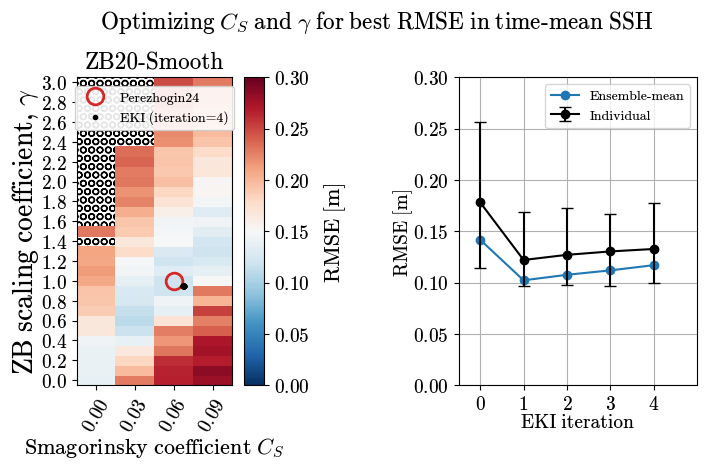

In [193]:
def plot(iteration=0):
    default_rcParams({'axes.formatter.limits': (-3,3), 'figure.subplot.wspace': 0.6})
    fig = plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plot_panels(['ZB-stress-pass-4-sel-1'], ['ZB20-Smooth'], **ssh)
    plt.plot(0.06,1.0,color='tab:red', marker='o', markerfacecolor='none', markeredgewidth=2, markersize=12, label='Perezhogin24', ls='')

    plt.plot(metrics.Cs[iteration], metrics.ZB[iteration], '.', color='k', label=f'EKI (iteration={iteration})')
    plt.legend(bbox_to_anchor=(0.5,0.9), loc='center', framealpha=0.9, fontsize=10)

    plt.subplot(1,2,2)
    plt.plot(np.arange(iteration+1), rmse_mean_train[:iteration+1], marker='o', label='Ensemble-mean')
    #plt.plot(np.arange(iteration+1), rmse_mean_test[:iteration+1], marker='o', label='Ensemble-mean (10y)')
    plt.title('')
    plt.ylabel('RMSE [m]')
    plt.ylim([0.00,0.3])
    plt.xticks(np.arange(5))
    plt.xlim([-0.5,5])
    plt.grid()
    plt.xlabel('EKI iteration')
    ymin = rmse_train.min('ens')[:iteration+1]
    ymax = rmse_train.max('ens')[:iteration+1]
    ymid = rmse_train.mean('ens')[:iteration+1]

    yerr = np.vstack([ymid - ymin, ymax - ymid])
    plt.errorbar(np.arange(iteration+1), ymid, yerr=yerr, fmt='o', capsize=4, color='k', label='Individual', ls='-')
    plt.legend(fontsize=10)
    
    plt.suptitle('Optimizing $C_S$ and $\gamma$ for best RMSE in time-mean SSH', y=1.05)
plot(4)

In [317]:
create_animation_ffmpeg(plot, np.arange(5), filename='Double-Gyre-EKI.mp4', FPS=1)

Frames already exists in folder .ffmpeg/Double-Gyre-EKI


Do you want to update snapshots?: [y/n] y


Savefig .ffmpeg/Double-Gyre-EKI/frame-0.png
Savefig .ffmpeg/Double-Gyre-EKI/frame-1.png86
Savefig .ffmpeg/Double-Gyre-EKI/frame-2.png4
Savefig .ffmpeg/Double-Gyre-EKI/frame-3.png86
Savefig .ffmpeg/Double-Gyre-EKI/frame-4.png74
Native resolution of snapshots is used: 1406x934

Animation Double-Gyre-EKI.mp4 at FPS=1 will last for 5.0 seconds. The frames are saved to 
.ffmpeg/Double-Gyre-EKI

Running the command:
cd /home/pp2681/calibration/notebooks; ffmpeg -y -framerate 1 -i .ffmpeg/Double-Gyre-EKI/frame-%d.png -s:v 1406x934 -c:v libx264 -profile:v high -crf 20 -pix_fmt yuv420p Double-Gyre-EKI.mp4


ffmpeg version 4.2.4-1ubuntu0.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.3.0-10ubuntu2)
  configuration: --prefix=/usr --extra-version=1ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-l

# Emulate stage

In [2]:
metrics = xr.open_dataset('/scratch/pp2681/mom6/Apr2023/R4-sensitivity/Vanilla-EKI-ens-size-20/metrics.nc')

In [19]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C

# X: (100, 2) input points
# Ys: (100, 440) output values for each GP
X = np.stack([metrics.Cs.stack(z=('iter','ens')), metrics.ZB.stack(z=('iter','ens'))],-1)
Ys = metrics.ssh_coarse.stack(z=('iter','ens')).stack(t=['yh', 'xh']).values

# Remove exploded experiments
X = np.delete(X, 18, axis=0)
Ys = np.delete(Ys, 18, axis=0)

gps = []
for i in range(440):
    #print(f'{i} spatial coordinate')
    y = Ys[:, i]
    kernel = C(1.0, (1e-1, 1e1)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e1)) \
           + WhiteKernel(noise_level=1e-1, noise_level_bounds=(1e-3, 1e0))
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5)
    gp.fit(X, y)
    gps.append(gp)

# Compute Likelihood as a function of inputs

In [40]:
def likelihood(Cs, ZB, gps, yobs):
    '''
    Cs and ZB are 1d arrays or scalars
    '''
    _X, _Y = np.meshgrid(Cs, ZB)
    X_test = np.stack([_X.ravel(), _Y.ravel()],-1)

    Y_mean = []
    Y_std = []
    for gp in gps:
        y_mean, y_std = gp.predict(X_test, return_std=True)
        Y_mean.append(y_mean)
        Y_std.append(y_std)
    
    Y_mean = np.stack(Y_mean, axis=1)
    Y_std = np.stack(Y_std, axis=1)

    logLK =  - 0.5 * (((Y_mean - yobs)**2) / (Y_std**2)).sum(-1) - \
               0.5 * np.sum(np.log(2 * np.pi * (Y_std**2)), -1)
            
    LK = np.exp(logLK)

    RMSE = np.sqrt(np.mean((Y_mean - yobs)**2, -1))
    
    return _X, _Y, Y_mean, Y_std, LK, logLK, RMSE

Text(0.5, 1.0, 'Emulator std')

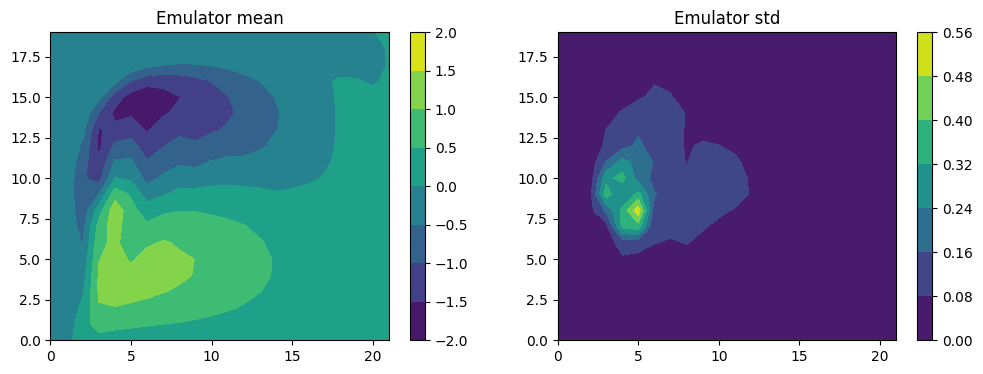

In [32]:
_X, _Y, Y_mean, Y_std, LK, logLK = likelihood([0.06],[1.0],gps,metrics.ssh_fine.values.ravel())

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.contourf(Y_mean.reshape([20,22]), levels=np.arange(-2,2.5,0.5))
plt.colorbar()
plt.title('Emulator mean')

plt.subplot(1,2,2)
plt.contourf(Y_std.reshape([20,22]))
plt.colorbar()
plt.title('Emulator std')

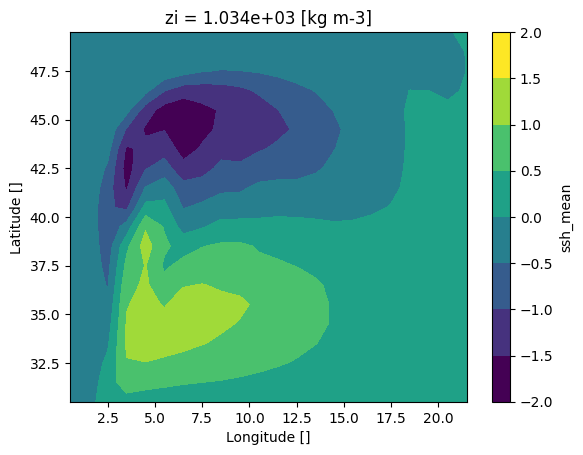

In [37]:
ds['ZB-stress-pass-4-sel-1-Cs-0.06-ZB-1.0_R1'].ssh_mean.plot.contourf(vmin=-2, vmax=1.6, cmap='viridis', levels=np.arange(-2,2.5,0.5))

In [41]:
_X, _Y, Y_mean, Y_std, LK, logLK, RMSE = likelihood(np.linspace(0,0.11,100),np.linspace(0,3.0,100),gps,metrics.ssh_fine.values.ravel())

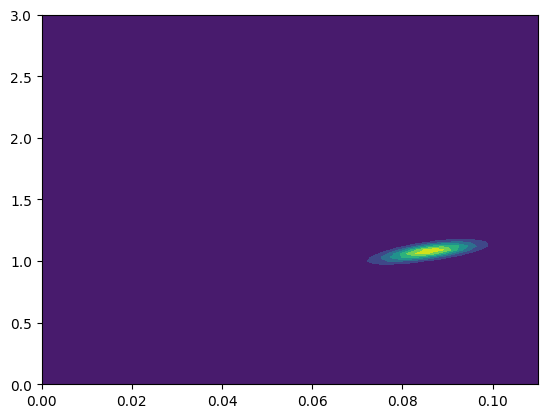

In [39]:
im = plt.contourf(_X,_Y,LK.reshape(100,100))
#plt.colorbar(im)

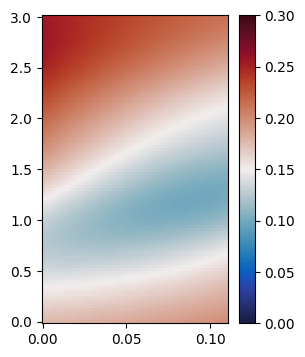

In [46]:
fig = plt.figure(figsize=(3,4))
plt.pcolormesh(_X,_Y,RMSE.reshape(100,100), vmin=0, vmax=0.3, cmap=cmocean.cm.balance)
plt.colorbar()

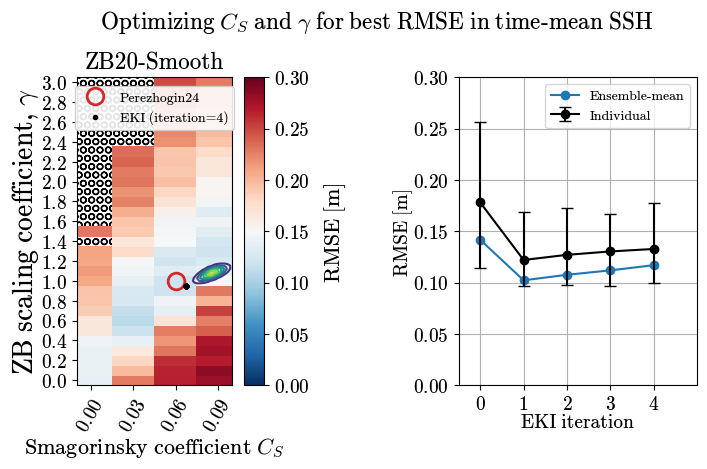

In [202]:
def plot(iteration=0):
    default_rcParams({'axes.formatter.limits': (-3,3), 'figure.subplot.wspace': 0.6})
    fig = plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plot_panels(['ZB-stress-pass-4-sel-1'], ['ZB20-Smooth'], **ssh)
    plt.plot(0.06,1.0,color='tab:red', marker='o', markerfacecolor='none', markeredgewidth=2, markersize=12, label='Perezhogin24', ls='')

    plt.plot(metrics.Cs[iteration], metrics.ZB[iteration], '.', color='k', label=f'EKI (iteration={iteration})')
    plt.contour(_X,_Y,LK.reshape(100,100), label='posterior')
    plt.xlim([-0.01, 0.1])

    plt.legend(bbox_to_anchor=(0.5,0.9), loc='center', framealpha=0.9, fontsize=10)


    plt.subplot(1,2,2)
    plt.plot(np.arange(iteration+1), rmse_mean_train[:iteration+1], marker='o', label='Ensemble-mean')
    #plt.plot(np.arange(iteration+1), rmse_mean_test[:iteration+1], marker='o', label='Ensemble-mean (10y)')
    plt.title('')
    plt.ylabel('RMSE [m]')
    plt.ylim([0.00,0.3])
    plt.xticks(np.arange(5))
    plt.xlim([-0.5,5])
    plt.grid()
    plt.xlabel('EKI iteration')
    ymin = rmse_train.min('ens')[:iteration+1]
    ymax = rmse_train.max('ens')[:iteration+1]
    ymid = rmse_train.mean('ens')[:iteration+1]

    yerr = np.vstack([ymid - ymin, ymax - ymid])
    plt.errorbar(np.arange(iteration+1), ymid, yerr=yerr, fmt='o', capsize=4, color='k', label='Individual', ls='-')
    plt.legend(fontsize=10)
    
    plt.suptitle('Optimizing $C_S$ and $\gamma$ for best RMSE in time-mean SSH', y=1.05)
plot(4)